In [88]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

In [89]:
max_lunghezza_albero = 100
random_state = None ##davvero random 
# random_state = 5 ##un integer qualsiasi, prende sempre gli stessi numeri random ogni volta che lanci

In [90]:
df = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat60.1.csv' , sep=';' , decimal='.')
df.set_index('Time', inplace=True)
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,Mag,UP,DOWN
Time,,,,,,,,,,,,
0,9.22379,3.05962,0.12397,0.51117,-2.25067,0.70190,992.16357,-18.34967,89.23000,0.98724,0,0
1,9.17947,2.79313,-0.25272,-0.95367,1.96075,5.27954,992.16168,-16.91789,88.42297,0.97367,0,0
2,8.44765,2.48770,-0.44915,-6.32476,11.17705,6.62231,992.16187,-16.38699,86.95651,0.94906,0,0
3,6.54864,1.69121,-0.10720,-0.95367,34.24833,3.13568,992.15485,-14.47858,89.06219,0.98415,0,0
4,5.08021,0.88573,0.85938,7.22503,32.60037,-7.54546,992.15295,-9.75418,80.39864,0.83562,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
586,7.48827,3.96152,3.63214,-5.59997,-9.02557,-1.50299,992.21906,-25.45410,64.12453,0.60595,0,1
587,6.51870,3.48722,3.90463,2.02942,-4.26483,-0.95367,992.15930,-24.65161,59.07883,0.53297,0,0
588,8.77344,4.69394,3.78306,-3.58581,-3.04413,1.60980,992.20844,-26.16444,66.67456,0.64462,0,0


## DecisionTree Classifier

Accuracy:   1.0
Precision:  0.25
Recall:     0.5


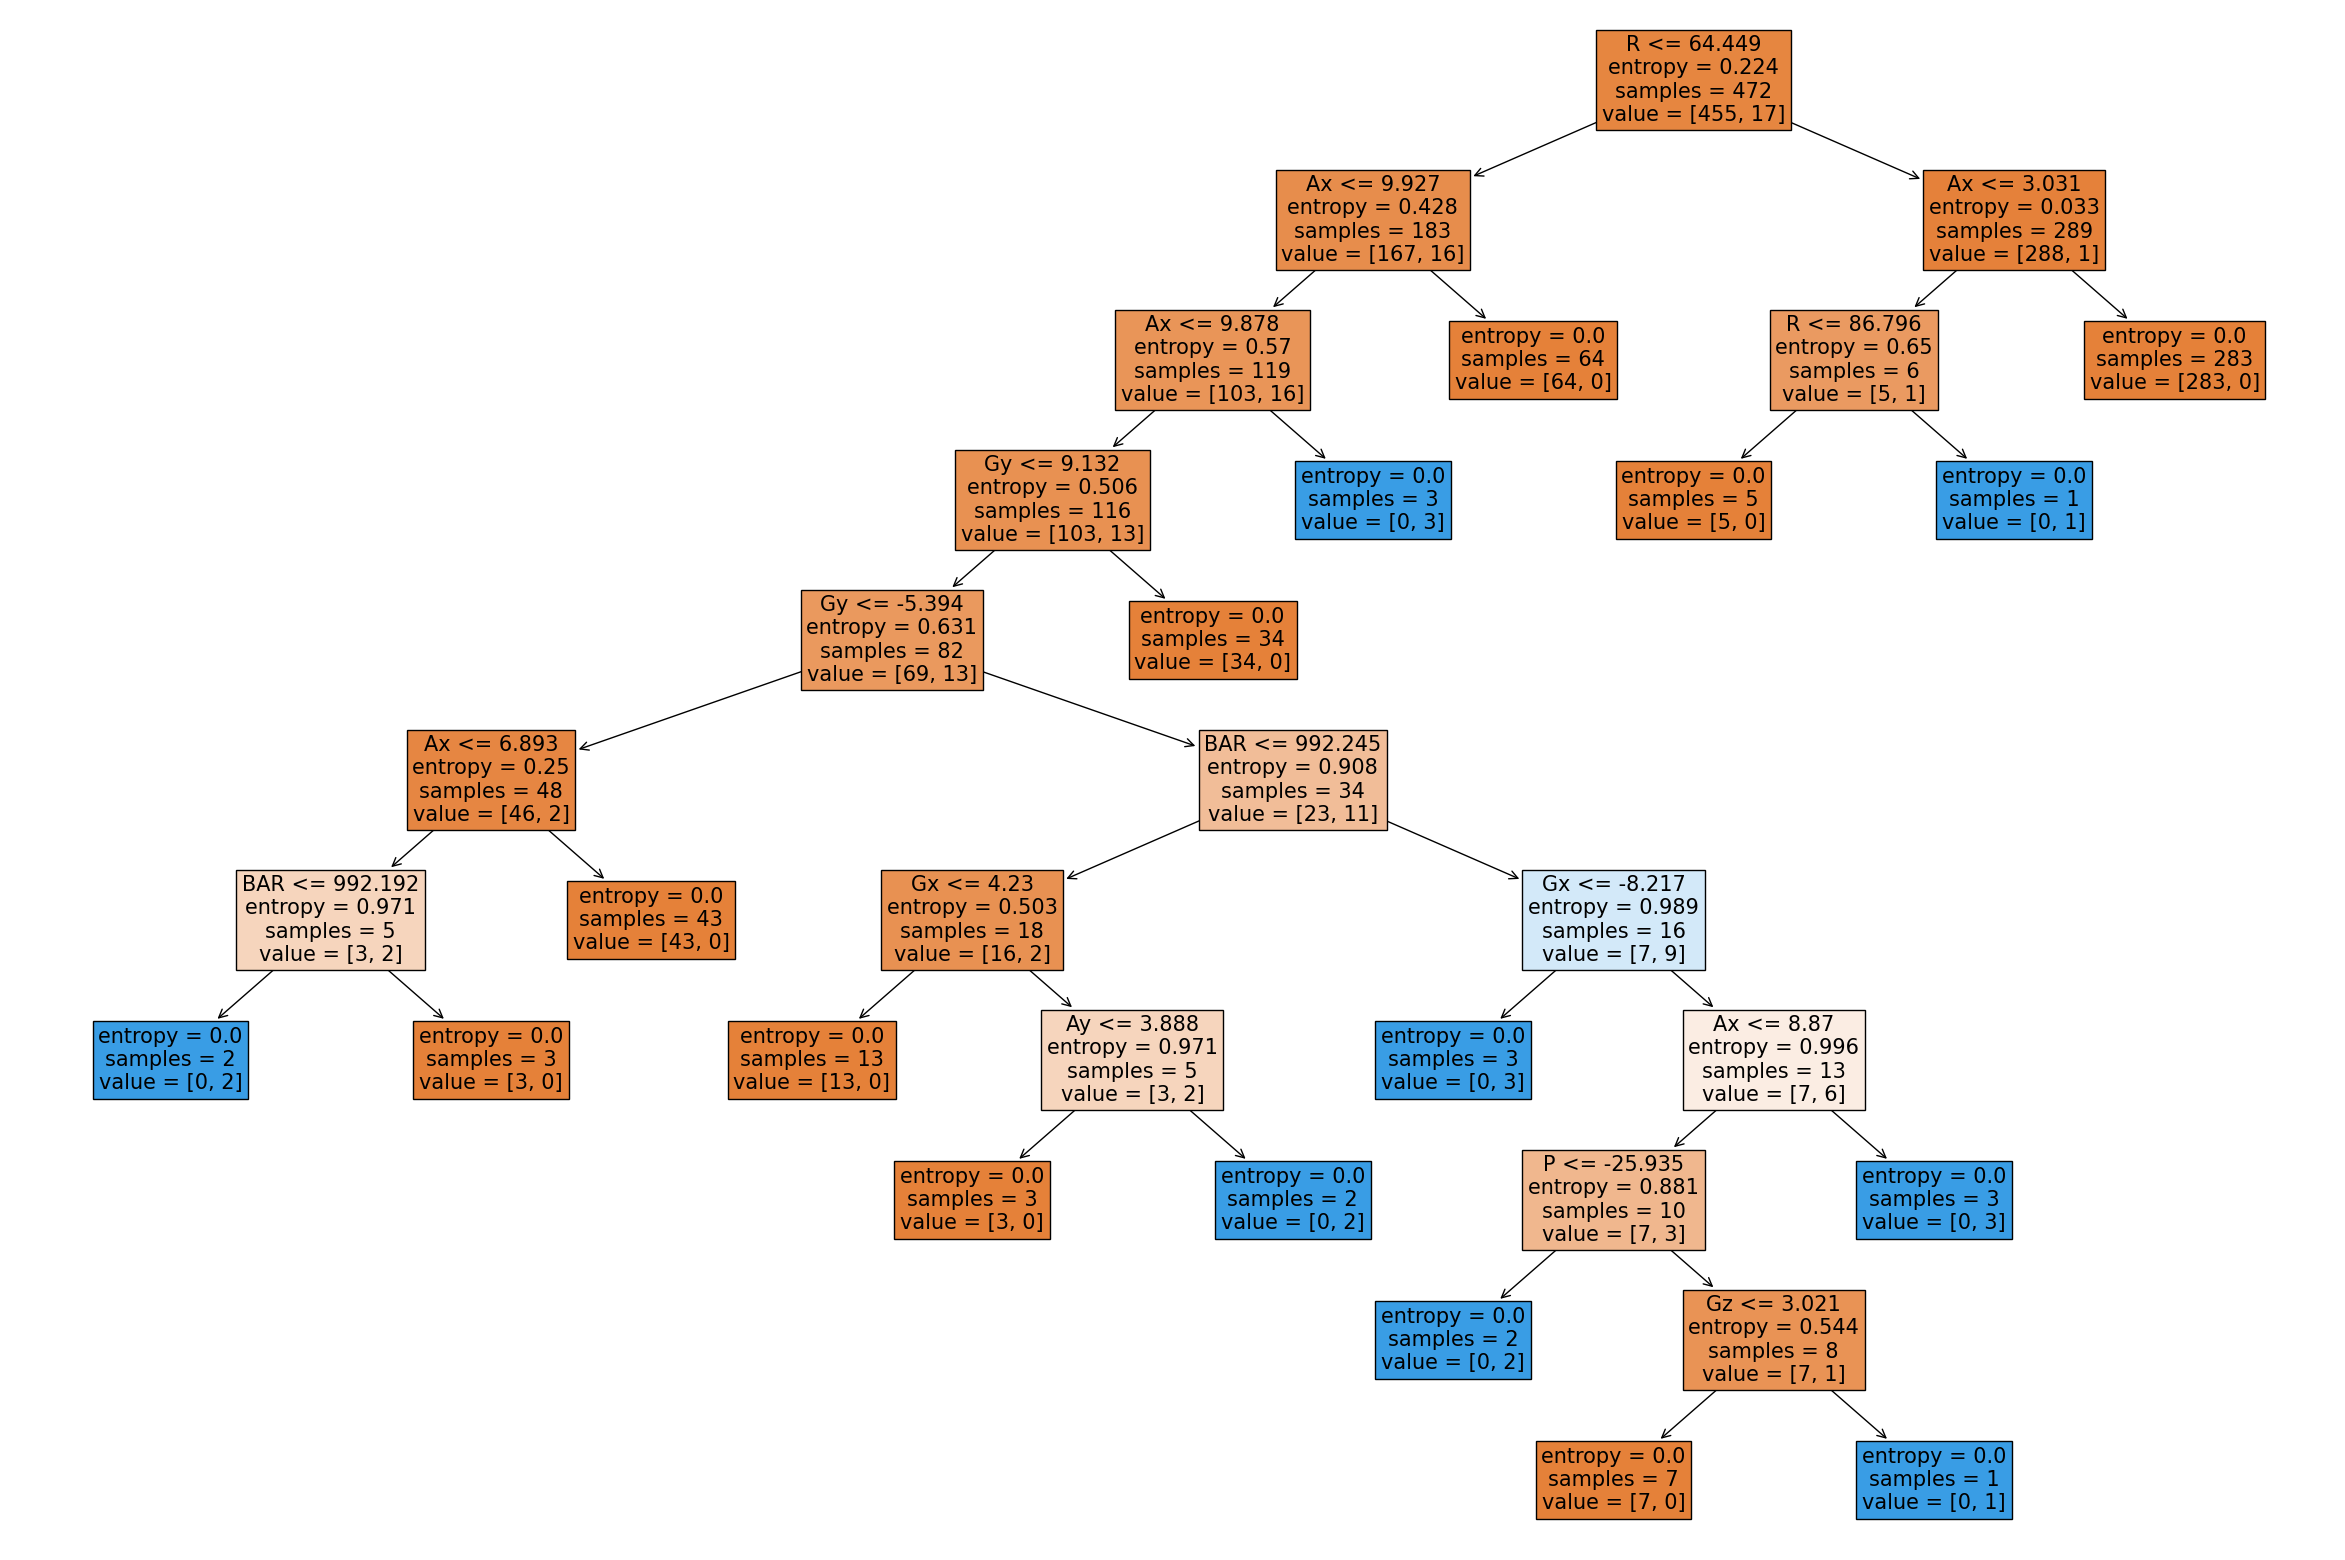

In [91]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 

y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_lunghezza_albero )
# clf = DecisionTreeClassifier(max_depth=max_lunghezza_albero)
# clf = DecisionTreeRegressor(ccp_alpha=0.01, max_depth=4)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


            0
Ax   0.346318
R    0.204432
Gy   0.149987
BAR  0.102796
Gx   0.067035
Ay   0.045974
P    0.042278
Gz   0.041180
Az   0.000000
UP   0.000000


<AxesSubplot:>

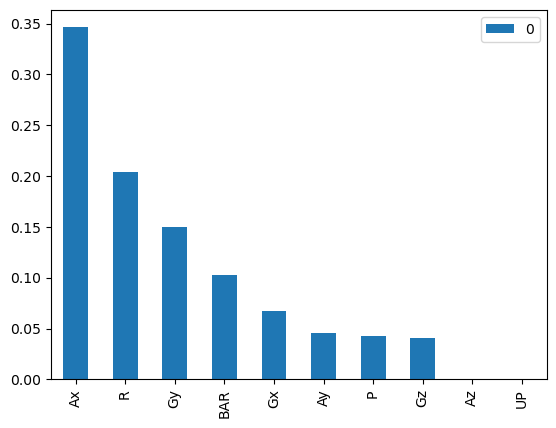

In [92]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
feature_importance.head(10).plot(kind='bar')

## DecisionTree Regreession

Accuracy:   1.0
Precision:  0.0
Recall:     0.0


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


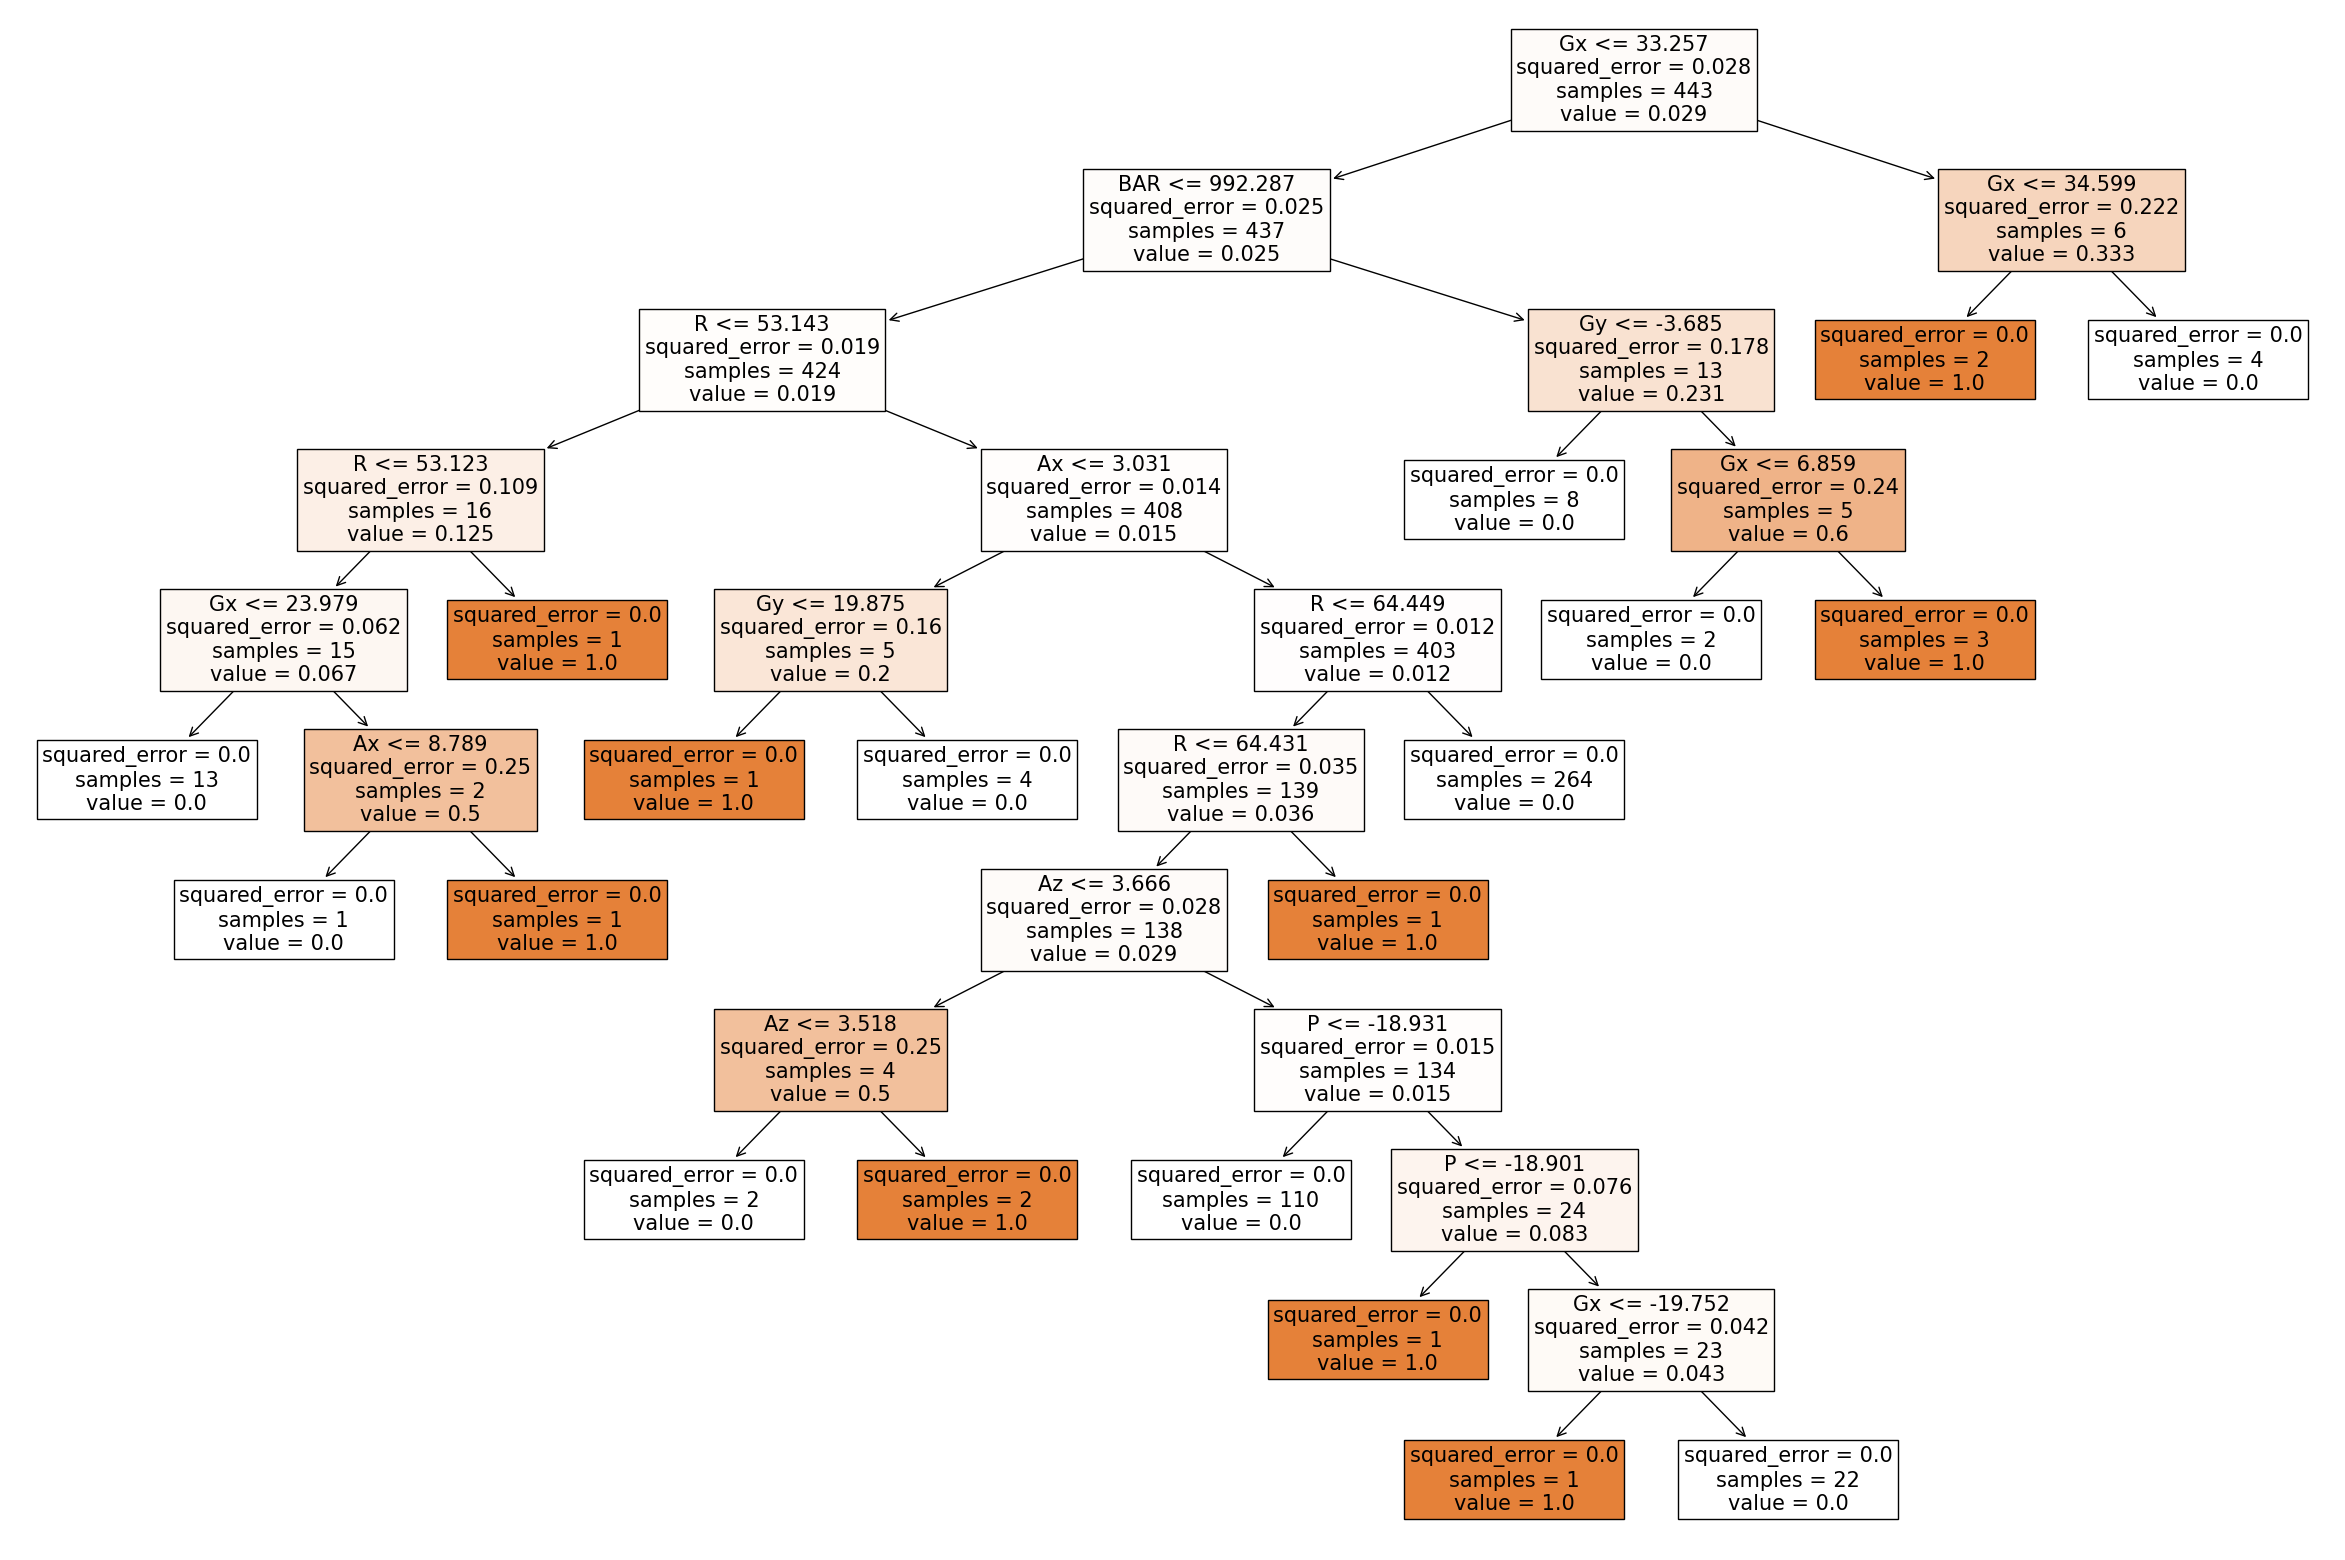

In [93]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 

y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
clr = DecisionTreeRegressor(max_depth=max_lunghezza_albero)
clr = clr.fit(X_train, y_train)
param = clr.get_params()
predictions = clr.predict(X_test)
accuracy = clr.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clr, 
        feature_names=feature_names, 
        filled=True, fontsize=15)

            0
Gx   0.355450
R    0.163083
Az   0.151675
Gy   0.151182
P    0.080329
Ax   0.053398
BAR  0.044884
Ay   0.000000
Gz   0.000000
UP   0.000000


<AxesSubplot:>

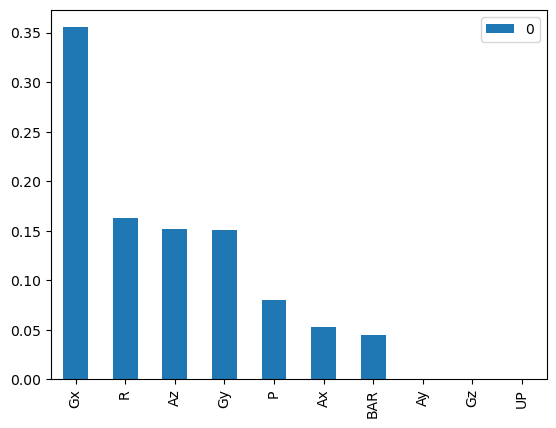

In [94]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clr.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
feature_importance.head(10).plot(kind='bar')

## Logistic Regression

In [95]:
log_reg = LogisticRegression(random_state=None, solver = 'lbfgs', max_iter=10000)
log_reg.fit(X_train, y_train)

# Methods we can use in Logistic

# predict - Predict class labels for samples in X
log_reg.predict(X_train)
y_pred = log_reg.predict(X_train)

# predict_proba - Probability estimates
pred_proba = log_reg.predict_proba(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

array([[-0.26679102, -0.54815152,  0.67485311,  0.06005707,  0.03438526,
        -0.08883013, -0.00337301, -0.01113196,  0.01153676, -0.0121071 ]])

In [96]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report


LogReg Training Accuracy is:  0.9683972911963883
LogReg Testing Accuracy is:  0.9594594594594594


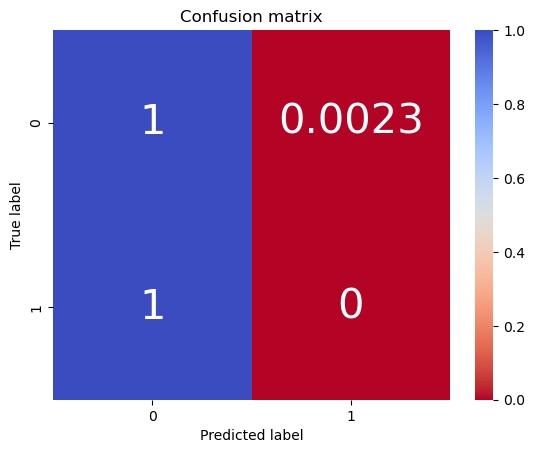

In [97]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [98]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)


##Total averages :
print("")
print("The average TPR is:", TPR.mean())

print("The average Precision is:", PPV.mean())
print("The average False positive rate is:", FPR.mean())
print("The average False Negative Rate is:", FNR.mean())

The True Positive Rate is: [0.99767442 0.        ]
The Precision is: [0.97058824 0.        ]
The False positive rate is: [1.         0.00232558]
The False Negative Rate is:  [0.00232558 1.        ]

The average TPR is: 0.49883720930232556
The average Precision is: 0.4852941176470588
The average False positive rate is: 0.5011627906976744
The average False Negative Rate is: 0.5011627906976744


### Regressione Lineare Multivariata

       Weight
Reg          
BAR   0.34703
UP  -0.006085
Az  -0.006022
Ax  -0.005054
R   -0.002578
Gx   0.001704
P    0.001532
Gz  -0.001445
Ay  -0.001128
Gy   0.000767
Termine noto: -344.00430526634267
 
MLR:  0.0531319233109101


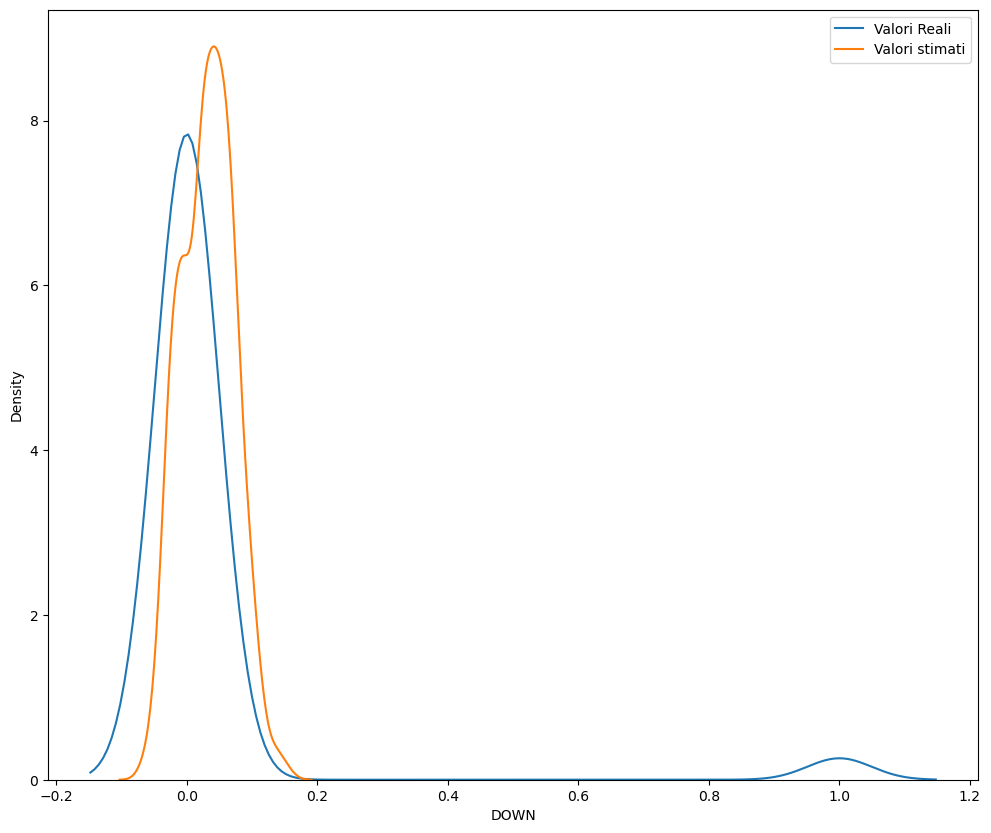

In [99]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'Weight'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='Weight', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('MLR: ', mlr.score(X, y))
plt.figure(figsize=(12, 10))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
